# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import norm

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [72]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


In [73]:
list(data.columns.values)

['id',
 'ad',
 'education',
 'ofjobs',
 'yearsexp',
 'honors',
 'volunteer',
 'military',
 'empholes',
 'occupspecific',
 'occupbroad',
 'workinschool',
 'email',
 'computerskills',
 'specialskills',
 'firstname',
 'sex',
 'race',
 'h',
 'l',
 'call',
 'city',
 'kind',
 'adid',
 'fracblack',
 'fracwhite',
 'lmedhhinc',
 'fracdropout',
 'fraccolp',
 'linc',
 'col',
 'expminreq',
 'schoolreq',
 'eoe',
 'parent_sales',
 'parent_emp',
 'branch_sales',
 'branch_emp',
 'fed',
 'fracblack_empzip',
 'fracwhite_empzip',
 'lmedhhinc_empzip',
 'fracdropout_empzip',
 'fraccolp_empzip',
 'linc_empzip',
 'manager',
 'supervisor',
 'secretary',
 'offsupport',
 'salesrep',
 'retailsales',
 'req',
 'expreq',
 'comreq',
 'educreq',
 'compreq',
 'orgreq',
 'manuf',
 'transcom',
 'bankreal',
 'trade',
 'busservice',
 'othservice',
 'missind',
 'ownership']

In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4870 entries, 0 to 4869
Data columns (total 65 columns):
id                    4870 non-null object
ad                    4870 non-null object
education             4870 non-null int8
ofjobs                4870 non-null int8
yearsexp              4870 non-null int8
honors                4870 non-null int8
volunteer             4870 non-null int8
military              4870 non-null int8
empholes              4870 non-null int8
occupspecific         4870 non-null int16
occupbroad            4870 non-null int8
workinschool          4870 non-null int8
email                 4870 non-null int8
computerskills        4870 non-null int8
specialskills         4870 non-null int8
firstname             4870 non-null object
sex                   4870 non-null object
race                  4870 non-null object
h                     4870 non-null float32
l                     4870 non-null float32
call                  4870 non-null float32
city        

### Preliminary Analysis:

In [26]:
w = data[data.race == 'w']
b = data[data.race == 'b']

print( 'w:', len(w))
print( 'b:', len(b))

w: 2435
b: 2435


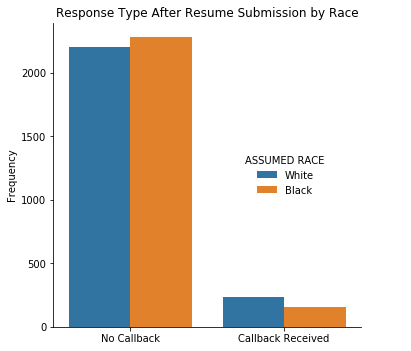

In [94]:
# Graph Data 

# Create a frequency graph of callback status by race:
fig = sns.catplot(x='call',hue='race', data=data, kind='count')

# Customize the legend:
fig._legend.set_title('ASSUMED RACE                         ')
for text, label in zip(
    fig._legend.texts, 
    ['White', 'Black                         ']
): text.set_text(label)

# Label tick marks, axes and add a title:
fig.set_xticklabels(['No Callback','Callback Received'])
fig = plt.xlabel('')
fig = plt.ylabel('Frequency')
fig = plt.title('Response Type After Resume Submission by Race')

Based off of the preliminary graphical respresentation of the data, it appears that applicants with blac-sounding names experience fewer callbacks from potential employers. However, the statistical significance of difference in callbacks received in this sample needs to be analyzed.

In [101]:
# Create callback variables for w and b
w_callbacks = data.call[data.race == 'w'].sum()
b_callbacks = data.call[data.race == 'b'].sum()

# Create resume variables for w and b
w_resumes = len(w)
b_resumes = len(b)

print( 'w resumes submitted:', w_resumes)
print( 'w callbacks:', w_callbacks)
print( '   ' )
print( 'b resumes submitted:', b_resumes)
print( 'b callbacks:', b_callbacks)

w resumes submitted: 2435
w callbacks: 235.0
   
b resumes submitted: 2435
b callbacks: 157.0


### 1. What test is appropriate to perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes? Does CLT apply?

**Answer:** 
- Since the difference in rate of callbacks for two separate groups is compared, a *Two-Proportion  $z$-Test* is most appropriate.
- Under the Central Limit Theorem (CLT), the sampling distribution of the sample means approaches a normal distribution as the sample size ($n$) gets larger - regardless of what the shape of the population distribution. A sample is considered large when $n$ >= 30. Since w-$n$-callbacks = 235 *(>30)* and b-$n$-callbacks = 157 *(>30)*, CLT applies.

### 2. What are the null and alternate hypotheses?

$H$o: There is no difference between the proportion of callbacks for white-sounding names and black-sounding names. <br> $p̂_{white-callbacks}$ − $p̂_{black-callbacks}$ = 0 

$H$a: There is a difference between the proportion of callbacks for white-sounding names and black-sounding names. <br> $p̂_{white-callbacks}$ − $p̂_{black-callbacks}$ ≠ 0

Significance Level: *95%* Confidence. <br> $α$ = 0.05

### 3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.

#### Method 1: Bootstrap Inferential Statistics
Two-Sample Bootstrap Hypothesis Test for Difference of Proportions

In [105]:
# Define sample population proportions
w_proportion = w_callbacks / w_resumes
b_proportion = b_callbacks / b_resumes

In [106]:
# Calculate group proportions and difference between proportions
diff_of_props = w_proportion - b_proportion

# Assuming null hypothesis is true, bootstrap proportion will = 0
boot_diff_props = 0

In [110]:
# Calculate the p-value
p_val = np.sum(diff_of_props >= boot_diff_props)
p_val

1

In [111]:
# Calculate population and combined standard error
w_err = w_proportion*(1 - w_proportion)/w_resumes
b_err = b_proportion*(1 - b_proportion)/b_resumes
standard_err = np.sqrt(w_err + b_err)

# Define the z-critical value for 0.05 significance level
z_critical = norm.ppf(1 - 0.5*0.05)

# Calculate Margin of Error using Standard Error and the z-Critical Value
margin_err = z_critical * standard_err

In [112]:
# Calculate the confidence intervals
confidence_lower = b_proportion - w_proportion - margin_err
confidence_higher = b_proportion - w_proportion  + margin_err

print('Difference of Proportions: {0:0.4f}'.format(diff_of_props))
print('p-value: {0:0.4f}'.format(p_val))
print('Margin of Error: {0:0.4f}'.format(margin_err))
print('95% Confidence Interval: [ {0:0.4f}  {1:0.4f} ]'.format(confidence_lower, confidence_higher))

Difference of Proportions: 0.0320
p-value: 1.0000
Margin of Error: 0.0153
95% Confidence Interval: [ -0.0473  -0.0168 ]


**Conclusion from Two-Proportion Bootstrap Test:** The empirical difference of proportions (0.0320) falls outside of the 95% Confidence Interval (-0.0473 , -0.0168) with a p-value of 1 showing there is no correlation between the boostrap proportion and the empirical data's difference of proportion. This indicates that applicants with white-sounding names experience different callback rates than applicants with black-sounding names. $Ho$ is rejected.

#### Method 2: Frequentist Inferential Statistics
*Two-Proportion  $z$-Test*

In [113]:
def two_proportion_z_test(callbacks1, resumes1, callbacks2, resumes2, one_tailed=False):
    """Return z-statistic and p-value."""
    
    # Calculate proportions:
    proportion1 = callbacks1/resumes1
    proportion2 = callbacks2/resumes2
    proportion = (callbacks1 + callbacks2)/(resumes1 + resumes2)
    
    # Calculate standard error:
    standard_err = np.sqrt(proportion * (1-proportion) * (1/resumes1 + 1/resumes2))
    
    # Calculate and return z-statistic and p-value:
    z = (proportion1 - proportion2)/standard_err
    p = 1 - stats.norm.cdf(abs(z))
    
    # If one_tailed = False(0), then p *= 2 is calculated:
    p *= 2 - one_tailed
    
    return z, p

In [114]:
z, p = two_proportion_z_test(w_callbacks, w_resumes, b_callbacks, b_resumes)

print('z-score: {0:0.4f}'.format(z))
print('p-value: {0:0.4f}'.format(p))
print('95% Confidence Interval: [ {0:0.4f}  {1:0.4f} ]'.format(confidence_lower, confidence_higher))



z-score: 4.1084
p-value: 0.0000
95% Confidence Interval: [ -0.0473  -0.0168 ]


**Conclusion from Two-Proportion  $z$-Test:** The $z$-score (4.1084) falls outside the 95% confidence interval (-0.0473 , -0.0168) indicating the pattern exhibited is probably too unusual to be just due to random chance; this is reflected by the small p-value. In this case, it is possible to reject the null hypothesis. **$Ho$ is rejected**.

### 4. Write a story describing the statistical significance in the context or the original problem.

Marianne Bertrand and Sendhil Mullainathan from the University of Chicago Booth's Jameel Poverty Action Lab (J-PAL) conducted a field study to assess the effect of racial discrimination in the U.S. labor market. Identical resumes were randomly assignined to black-sounding or white-sounding names in order to analyze the effect of race on callback success. Assuming the experiment controls were appropriate for all factors related to callbacks, the results from this analysis indicates that racial discrimination in the United States labor market is statisically significant. Matching resumes with white-sounding names are more likely to receive a callback than their counterparts with black-sounding names.

### 5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

While this analysis shows that the perceived race of an applicant based off of the name printed on the resume does have a significant effect on the incidence of callbacks, no other factors were analyzed in this study. Therefore, it would be a sweeping generalization to make the claim that race is the most important factor in callback success.

The study protocal states that resumés varied by quality, with higher quality resumes featuring extracurricular activities such as school-year employment, and gender. Since these and other categorical variables within the dataet are recorderd, assessing any correlation between variables and each variable's impact on callback success would be a useful means of creating a larger picture of the true factors associated with callbacks. This can be easily accomplished by performing additional *Two-Proportion $z$-Test* as compared to callbacks, like the statistical analysis applied above.